<a href="https://colab.research.google.com/github/juanlu29/juanlu29/blob/contaminacionMadrid/preprocesadoDatosContaminacionMadrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Visualizacion de datos de contaminacion de Madrid. Hasta ahora dispongo de 

## Plaza del Cármen, NO2
## Casa de campo, NO2, O3
## Plaza elíptica, Fernández Ladreda,  NO2

Cuatro datasets

El formato es diario partiendo del día 1-1-2010 y las unidades mg/m^3

In [ ]:
import pandas as pd
from google.colab import drive
import numpy as np
drive.mount('/content/drive/')

# Exploramos los directorios de drive. Cambiamos directorio a donde estan los datos
%cd /content/drive/My\ Drive/datosContaminacionMadrid

# Lo pasamos a dataframes
est56NO2_df = pd.read_csv('Est56FL_CodPar08NO2_valuesonly.txt', header=0)
est24NO2_df = pd.read_csv('Est24CC_CodPar08NO2_valuesonly.txt', header=0)
est03NO2_df = pd.read_csv('Est03PlC_CodPar08NO2_valuesonly.txt', header=0)
est03O3_df  = pd.read_csv('Est03PlC_CodPar14O3_valuesonly.txt', header=0)




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/datosContaminacionMadrid


Visualizacion interactiva de datos

In [ ]:
import altair as alt
from vega_datasets import data



alt.Chart(est56NO2_df.reset_index()).mark_point().encode(
    x='index',
    y='x',
).interactive()



alt.Chart(...)

In [ ]:
alt.Chart(est03O3_df.reset_index()).mark_line().encode(
    x='index',
    y='x',
).interactive()

alt.Chart(...)

In [ ]:
alt.Chart(est03NO2_df.reset_index()).mark_line().encode(
    x='index',
    y='x',
).interactive()

alt.Chart(...)

## Calculo de correlaciones en los datos.

[86.62179614  1.81448874  6.0336363  ...  0.1649427   0.26229594
  0.49178062]
Frecuencia promedio de la señal : 0.22906997023299994
frecuencia maxima : [16.78952444]
Frecuencia máxima de la señal : [0.95442092]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 1

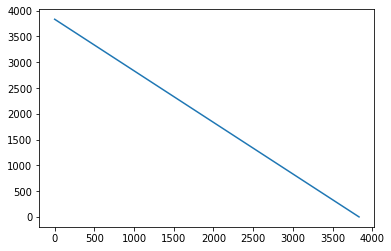

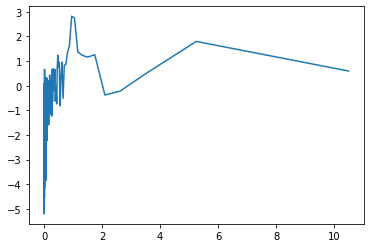

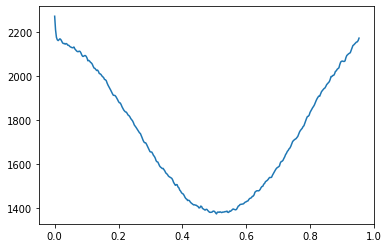

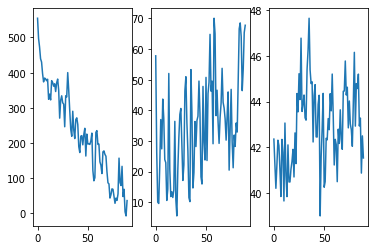

In [ ]:
import matplotlib.pyplot as plt
from scipy.fft import fft

def convolucionDiscreta(datos):
  '''
  Dada una serie temporal 1D, calcula su convolucion siendo ademas argumento de salida
  '''
  conv = []
  promediados = []
  longitudDatos = len(datos)
  for distanciaCorr in range(len(datos)):
    realizacionesParaPromediar = len(datos) - distanciaCorr # Numero de veces que podemos convulocionar el array sobre si mismo
    promediados.append(realizacionesParaPromediar)
    conv.append(0.)
    for muestra in range(realizacionesParaPromediar):
       conv[distanciaCorr] += datos[muestra]*datos[muestra + distanciaCorr]
       
    conv[distanciaCorr] = conv[distanciaCorr]/float(realizacionesParaPromediar)

  return np.asarray(correlacion), promediados

def averCorrCompt(serie,longitudProceso):
  '''
  Interpreta la serie temporal como un proceso estocástico estacionario en el cual podemos samplear muestras que 
  poseen las mismas propiedades estacionarias y asi analizar la correlacion de su ruido
  '''

  # Intentar el particionado de la serie temporal en subprocesos que evolucionan sobre un intervalo longitudProceso
  particiones = len(serie) // longitudProceso
  if particiones < 10:
    raise NameError("Son menos de 10 realizaciones para promediar")
  else:
    # Al ser un numpy array, debe ser necesario dividirse en partes iguales
    serie_p = serie[0:particiones*longitudProceso]
  particionado = np.split(serie_p,particiones)

  # Es una matriz
  correlacion = np.zeros([longitudProceso,longitudProceso])

  # Necesitamos derivar la media previamente
  media = np.zeros(longitudProceso)
  media = (1./float(particiones))*np.sum(particionado, axis=0)

  for i in range(longitudProceso): 
    for j in range(i,longitudProceso,1):
      # Promediado
      for k in range(particiones):
        correlacion[i,j] += (particionado[k][i]-media[i])*(particionado[k][j]-media[j])
      # Esta matriz es simétrica
      correlacion[j,i] = correlacion[i,j]

  # Normalizado de la matriz
  correlacion = correlacion*(1./float(particiones))
  return np.asarray(correlacion), np.asarray(media)





def frecuenciasInternas(datos,dx):
  '''
  Dada una serie de datos devuelve el espectro de frecuencias que lo compone y el dominio espectral correspondiente
  dx la unidad minima en la que el dominio esta particionado
  '''
  datosf = fft(datos)


  x = np.linspace(0.0, len(datos)*dx, len(datos))
  xf = np.linspace(0.0, 1.0/(2.0*dx), len(datos)//2)

  s_datosf_sq = np.real((2./len(datos))*np.sqrt(np.multiply(datosf,np.conj(datosf)))[0:len(datos)//2])

  return s_datosf_sq, xf

################

datos = est03O3_df.to_numpy()
#datos = est03NO2_df.to_numpy()

longitudDatos = len(datos)

correlacion = np.zeros(2000)
for j in range(2000):
  for i in range(1000):
    correlacion[j] += datos[i,0]*datos[j+i,0]
  correlacion[j] = 0.001*correlacion[j]

#plt.plot(correlacion)


correlacion, parapromediar = convolucionDiscreta(datos[:,0])
frecuencias, xf = frecuenciasInternas(datos[:,0],1.)
print(frecuencias)

#plt.plot(correlacion)

fig, ax = plt.subplots(1,1)
figf, axf = plt.subplots(1,1)

ax.plot(parapromediar)
#periodos = 1./(365.*xf)
#periodos[0] = 0.
periodos = xf[1:]
frecuencias = frecuencias[1:]
periodos = 1./(365.*periodos)
axf.plot(periodos,np.log(frecuencias))

C  = np.sum(frecuencias)

print( "Frecuencia promedio de la señal :",   np.sum(   np.multiply(   periodos , frecuencias/np.sum(frecuencias)    )    )    )
frecuenciaMaxima = np.where(frecuencias == np.amax(frecuencias)) # Operador & para evaular elemento a elemento entre arrays
print("frecuencia maxima :",frecuencias[frecuenciaMaxima])
print( "Frecuencia máxima de la señal :", periodos[frecuenciaMaxima])


fig_cor_p, ax_cor_p = plt.subplots(1,1)

x = np.arange(len(correlacion))
x = x*(1./365.)

acab = np.asarray(list(zip(x,correlacion)))

resultados = np.where(acab[:,0]<periodos[frecuenciaMaxima])
print(resultados[0])

#resultados = [np.array(zipped[0],zipped[1]) for zipped[0] < periodos[frecuenciaMaxima] in list(zip(x,correlacion))]

ax_cor_p.plot(acab[resultados[0],0],acab[resultados[0],1])

#fig.show()


#figf.show()

#fig_cor_p.show()

covMatrix, aver = averCorrCompt(datos[:,0],90)


aaa,(bbb1,bbb2,bbb3) = plt.subplots(1,3)
linea = covMatrix[0,:]
bbb1.plot(linea)
bbb2.plot(datos[:90,0])
bbb3.plot(aver)
aaa.show()

#plt.imshow(covMatrix)




Correlacion entre un punto y j : 0  siguientes
Correlacion entre un punto y j : 1  siguientes
Correlacion entre un punto y j : 2  siguientes
Correlacion entre un punto y j : 3  siguientes
Correlacion entre un punto y j : 4  siguientes
Correlacion entre un punto y j : 5  siguientes
Correlacion entre un punto y j : 6  siguientes
Correlacion entre un punto y j : 7  siguientes
Correlacion entre un punto y j : 8  siguientes
Correlacion entre un punto y j : 9  siguientes
Correlacion entre un punto y j : 10  siguientes
Correlacion entre un punto y j : 11  siguientes
Correlacion entre un punto y j : 12  siguientes
Correlacion entre un punto y j : 13  siguientes
Correlacion entre un punto y j : 14  siguientes
Correlacion entre un punto y j : 15  siguientes
Correlacion entre un punto y j : 16  siguientes
Correlacion entre un punto y j : 17  siguientes
Correlacion entre un punto y j : 18  siguientes
Correlacion entre un punto y j : 19  siguientes
Correlacion entre un punto y j : 20  siguientes
Co

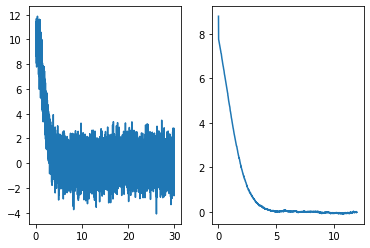

In [ ]:
import random

# Un ejemplo de juguete para ver si tiene sentido lo que estoy pensando
x = np.linspace(0,30,10000)
Sruido = 1.
ruido = Sruido*np.fromiter([random.gauss(0.0, 1.0) for i in range(10000)],float)
l = 5.
A = 10.
datos = A*np.exp(-np.power(x,2)/l) + ruido

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(x,datos)

correlacion = np.zeros(1000)
x_corr = np.zeros(1000)
f = 4
inc = 0
for j in range(1000):
  x_corr[j] = x[inc]
  print("Correlacion entre un punto y j :",j," siguientes")
  for i in range(10000-4000):
    correlacion[j] += datos[i]*datos[i+inc]
  correlacion[j] = correlacion[j]/(10000-4000)
  inc = inc + f

ax2.plot(x_corr,correlacion)

fig.show()


He probado a partir de la premisa que los datos corresponden a un proceso estocástico estacionario sobre el que calcular correlaciones para estimar cuantos puntos son suficientes para ser incorporados al entrenamiento de un proceso gaussiano. 

La realidad es que la correlacion nunca tiende estacionariamente a cero con los datos proporcionados (intentando que promediemos siempre sobre 20 realizaciones como minimo del proceso estocastico que conforma la serie temporal). He asumido que partiendo la serie temporal en trozos independientes estamos "sampleando" el proceso estocastico sobre el que obtenemos estas correlaciones.

Pues las correlaciones nunca tienden a cero, bien se hacen negativas y no somos capaces de calcular correlaciones a tiempos mas largos. El promedio del proceso estocastico es posible de computar pero son muy fluctuantes.

En el mejor de los casos me faltan datos para extraer la informacion que deseo de los datos y el hecho de que el proceso no tiende a una media constante pues implica que no es estacionario y no podemos hacer esta aproximación.

Creo que he confundido ciertos conceptos pero para esta serie temporal que modula no podemos presuponer un "conjunto de datos sobre que la memoria del proceso es cero si realizamos mas alla".

Proceso de Ornstein–Uhlenbeck

Voy a generar un proceso de esta naturaleza resolviendo la ec. diferencial estocástica pertinente y vamos a calcular su matriz de covarianza y vamos
a compararlo con la proveniente del kernel que hace que un proceso gausiano genere este tipo de trayectorias

Calculamos muestra
Calculamos correlaciones


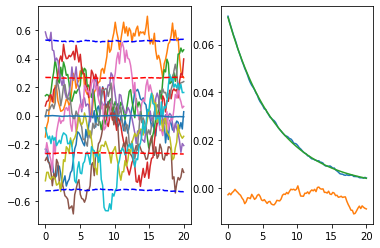

In [73]:
import pandas as pd


def procesoOU(n,dt,tau):
  '''
  Genera un proceso OU
  n es la longitud del proceso estocástico
  dt es el paso temporal
  tau es la escala caracteríística de tiempos del proceso
  '''

  def relacionRecursiva(i,dt,tau,xiou):
    '''
    Esta funcion es para calcular de forma recursiva los diferentes terminos del proceso OU
    '''
    if i == 0:
      xiou[0] = random.gauss(0,1)/np.sqrt(2*tau)
    else:
      xiou[i] = xiou[i-1]*np.exp(-dt/tau)+np.sqrt((1-np.exp(-(2*dt)/tau))/(2*tau))*random.gauss(0,1)

    return xiou[i]

  xiou = np.zeros(n)

  realizacionOU = np.asarray([ relacionRecursiva(i,dt,tau,xiou) for i in range(n)])

  return realizacionOU

def matrizCov(muestra,longitudProceso,realizaciones):
  '''
  La muestra es un iterable o lista con un numero determinado de muestras del proceso sobre el que calcular correlaciones
  '''

  # Es una matriz
  correlacion = np.zeros([longitudProceso,longitudProceso])

  # Necesitamos derivar la media previamente
  media = np.zeros(longitudProceso)
  media = (1./float(realizaciones))*np.sum(muestra, axis=0)

  # Promediando
  for k in range(realizaciones):
    vectorfila = np.array([muestra[k]-media])
    productosCovariantes = np.matmul(vectorfila.T,vectorfila)
    correlacion += productosCovariantes # Es una suma de matrices

  # Normalizado de la matriz
  correlacion = correlacion*(1./float(realizaciones))
  return np.asarray(correlacion), np.asarray(media)




n = 4000 # realizacones
m = 100 # longitud Proceso
dt = 0.2 # paso temporal
tau = 7. # Escala temporal del proceso

x = np.linspace(0,m*dt,m) # dominio del proceso

print("Calculamos muestra")
muestra = [procesoOU(m,dt,tau) for i in range(n)]

print("Calculamos correlaciones")
corr, media = matrizCov(muestra,m,n)

fig, (ax1,ax2) = plt.subplots(1,2)

ax2.plot(x,corr[0,:])
ax2.plot(x,media)
ax2.plot(x,(1./(2*tau))*np.exp(-x/tau))

[ax1.plot(x,muestra[i][:]) for i in range(10)]

sigma = np.asarray([np.sqrt(corr[i,i]) for i in range(m)])


data_set = {}
index = []
for i  in range(m):
  data_set['x'+str(i)] = corr[i,:]

for j in range(m):
  index.append("x"+str(j))

corr_csv = pd.DataFrame(data_set,index)
corr_csv.to_csv('K_OU_experimental.csv')

ax1.plot(x,media)
ax1.plot(x,sigma,'r--')
ax1.plot(x,1.98*sigma,'b--')
ax1.plot(x,-sigma,'r--')
ax1.plot(x,-1.98*sigma,'b--')

fig.show()